In [ ]:
import numpy as np
import qutip as qt
from tqdm import tqdm
from quantum.hamiltonian import g_t, closed, open
import pandas as pd
import matplotlib.pyplot as plt
from quantum.operators import get_operators, get_collapse
from quantum.run import solve
from quantum.non_classicality import coerence, entanglement
from scipy import integrate
from fractions import Fraction

# Coerence

In [ ]:
#==========================
# PARAMETERS -
#==========================
eps = 1e-10
limite = 1e-1
t = np.concatenate([
    np.linspace(0, 1, 100, endpoint=False),
    np.linspace(1, 200, 300)
])


N = 2       # Qubit Base Size
Nb = 45   # Field Base Size

args = {  'g0': 1,
          'eta': 1,
          'w': 0,
          'kappa': 1e-1,
          'gamma': 0,
          'gamma_phi': 1e-2,
          'coupling': 'exp',
          'phi': np.log(1e-3)
          }

extra = 'exp1'

In [9]:
wmax = (np.log(2) - np.log(1e-3))/100
w_list = np.linspace(0, wmax, 100)

In [10]:
#==========================
# INITIAL STATE
#==========================
alpha = np.sqrt(5)
phi0 = qt.tensor(qt.basis(N,0) + qt.basis(N,1), qt.coherent(Nb, alpha)).unit()
#phi0 = (tensor(basis(N,0), coherent(Nb, -alpha)) + tensor(basis(N,1), coherent(Nb, alpha))).unit()

In [11]:
#==========================
# OPERATORS
#==========================
sz, sp, sm, b, nb, I = get_operators(N, Nb)
obs_list=[sz, nb, nb**2]

#==========================
# DECAY AND DEPHASING
#==========================
c_ops = get_collapse(args, sm, sz, b)

#==========================
# CLOSED HAMILTONIAN
#==========================
H1 = closed(args, b, sp, sm)

In [12]:
state0 = phi0.copy()
sol_const_aberto = solve(H1, state0, t, c_ops, obs_list, args)
sol_const = solve(H1, state0, t, None, obs_list, args, open=False)

C_const_aberto = coerence(sol_const_aberto.states)
C_const = coerence(sol_const.states)

c_list_aberto = []
c_list = []

for w in tqdm(w_list):
  args['w'] = w
  H = open(b, sp, sm)

  sol_var_aberto = solve(H, state0, t, c_ops, obs_list, args)
  sol_var = solve(H, state0, t,  None, obs_list, args)

  C_var_aberto = coerence(sol_var_aberto.states)
  C_var = coerence(sol_var.states)
  c_list.append(C_var)
  c_list_aberto.append(C_var_aberto)

 78%|███████▊  | 78/100 [21:14<05:59, 16.34s/it] 


IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

In [ ]:
# ===============================
# 1) Formato genérico (sem π)
# ===============================

def fmt_dec(x, ndp=6):
    """
    Formata números para nomes de arquivo SEM ponto.
    Ex:
      0.1   -> "01"
      0.02  -> "002"
      1.0   -> "1"
      2.5   -> "25"
      10.75 -> "1075"
      -0.1  -> "m01"
    """
    if isinstance(x, int):
        return str(x)

    x = float(x)

    # se for "inteiro" numericamente
    if abs(x - round(x)) < 1e-12:
        return str(int(round(x)))

    sign = "m" if x < 0 else ""
    x = abs(x)

    # string fixa, evita notação científica
    s = f"{x:.{ndp}f}"          # ex: "0.020000"
    s = s.rstrip("0").rstrip(".")  # ex: "0.02"

    # remove o ponto
    s = s.replace(".", "")      # ex: "002"

    # remove zero à esquerda se for caso tipo "10.75" -> "1075" (fica ok)
    # mas preserva os zeros significativos de "0.02" -> "002" (não mexe)

    return sign + s


# ===============================
# 2) Formato só para φ (com π)
# ===============================
def fmt_pi(x):
    """
    Formata apenas φ em função de π quando possível.
    Exemplos: pi_2, 3pi_2, pi, 2pi, etc.
    """
    if abs(x) < 1e-12:
        return "0"

    ratio = x / np.pi

    try:
        frac = Fraction(ratio).limit_denominator(16)
    except Exception:
        frac = None

    if frac is not None:
        num, den = frac.numerator, frac.denominator

        if den == 1:
            if num == 1:
                return "pi"
            else:
                return f"{num}pi"

        if num == 1:
            return f"pi_{den}"
        else:
            return f"{num}pi_{den}"

    # se não encaixar bem como múltiplo de π, cai pro decimal seguro
    s = f"{x:.4f}"
    return s.replace('.', 'p').replace('-', 'm')


# ===============================
# 3) make_tag usando dec p/ tudo e π só p/ φ
# ===============================
def make_tag(N, Nb, args):
    return (
        f"N{fmt_dec(N)}_Nb{fmt_dec(Nb)}"
        f"_alpha{fmt_dec(alpha)}"
        f"_g0{fmt_dec(args['g0'])}"
        f"_eta{fmt_dec(args['eta'])}"
        f"_kappa{fmt_dec(args['kappa'])}"
        f"_gamma{fmt_dec(args['gamma'])}"
        f"_gphi{fmt_dec(args['gamma_phi'])}"
        f"_coup_{args['coupling']}"
        f"_phi{fmt_dec(args['phi'])}"
        #f"_phi{fmt_pi(args['phi'])}"   # <<< só φ em função de π
    )

# gera nome base
tag = make_tag(N, Nb, args)

# -------------------------------
# Converte listas → matrizes
# -------------------------------
Cmat_aberto  = np.vstack(c_list_aberto)   # (n_w, n_t)
Cmat_fechado = np.vstack(c_list)          # (n_w, n_t)

# ===============================
# Linhas = tempo, colunas = frequências
# ===============================
freq_cols = [float(w) for w in w_list]   # <<< nomes das colunas exatamente iguais às frequências

df_aberto  = pd.DataFrame(Cmat_aberto.T,  index=t, columns=freq_cols)
df_fechado = pd.DataFrame(Cmat_fechado.T, index=t, columns=freq_cols)

# constantes: 1 coluna por tipo, index = tempo
df_const_aberto = pd.DataFrame({"C_const_aberto": C_const_aberto}, index=t)
df_const        = pd.DataFrame({"C_const":        C_const},        index=t)

# -------------------------------
# Nomes dos arquivos
# -------------------------------
file_aberto       = f"./experiments/coerence/{args['coupling']}/{extra}/coerence_aberto_alpha{alpha}_{tag}.csv"
file_fechado      = f"./experiments/coerence/{args['coupling']}/{extra}/coerence_fechado_alpha{alpha}_{tag}.csv"
file_const_aberto = f"./experiments/coerence/{args['coupling']}/{extra}/coerence_const_aberto_alpha{alpha}_{tag}.csv"
file_const        = f"./experiments/coerence/{args['coupling']}/{extra}/coerence_const_alpha{alpha}_{tag}.csv"

# -------------------------------
# Salva tudo em CSV
# -------------------------------
df_aberto.to_csv(file_aberto)
df_fechado.to_csv(file_fechado)
df_const_aberto.to_csv(file_const_aberto)
df_const.to_csv(file_const)

print("CSV gerados:")
print(" -", file_aberto)
print(" -", file_fechado)
print(" -", file_const_aberto)
print(" -", file_const)


CSV gerados:
 - ./experiments/coerence/exp/coerence_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/coerence/exp/coerence_fechado_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/coerence/exp/coerence_const_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/coerence/exp/coerence_const_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv


In [ ]:
t_w = []
#limite = 1e-3
w_plot = w_list
for i, C_var in enumerate(c_list_aberto):
    C_var = np.array(C_var)
    idx = np.where(C_var < limite)[0]
    if len(idx) > 0:
        print(f"w = {w_plot[i]:.3f} → t = {t[idx[0]]:.4f}")
    else:
        print(f"w = {w_plot[i]:.3f} → nunca cai abaixo de {limite:.0e}")
    t_w.append(t[idx[0]])

idx = np.where(np.array(C_const_aberto)<limite)[0]
t_w.append(t[idx[0]])


w = 0.000 → t = 56.8271
w = 0.001 → t = 56.8271
w = 0.002 → t = 56.8271
w = 0.002 → t = 56.8271
w = 0.003 → t = 56.8271
w = 0.004 → t = 56.8271
w = 0.005 → t = 56.8271
w = 0.005 → t = 56.8271
w = 0.006 → t = 56.8271
w = 0.007 → t = 56.8271
w = 0.008 → t = 56.8271
w = 0.008 → t = 56.8271
w = 0.009 → t = 56.8271
w = 0.010 → t = 56.8271
w = 0.011 → t = 56.8271
w = 0.012 → t = 56.8271
w = 0.012 → t = 56.8271
w = 0.013 → t = 56.8271
w = 0.014 → t = 56.8271
w = 0.015 → t = 56.8271
w = 0.015 → t = 56.5789
w = 0.016 → t = 56.5789
w = 0.017 → t = 56.5789
w = 0.018 → t = 56.5789
w = 0.018 → t = 56.5789
w = 0.019 → t = 56.5789
w = 0.020 → t = 56.5789
w = 0.021 → t = 56.5789
w = 0.021 → t = 56.5789
w = 0.022 → t = 56.5789
w = 0.023 → t = 56.5789
w = 0.024 → t = 56.5789
w = 0.025 → t = 56.5789
w = 0.025 → t = 56.5789
w = 0.026 → t = 56.5789
w = 0.027 → t = 56.5789
w = 0.028 → t = 56.5789
w = 0.028 → t = 56.5789
w = 0.029 → t = 56.5789
w = 0.030 → t = 56.5789
w = 0.031 → t = 56.5789
w = 0.031 → t = 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\cesar\AppData\Local\Temp\ipykernel_40528\2772966936.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


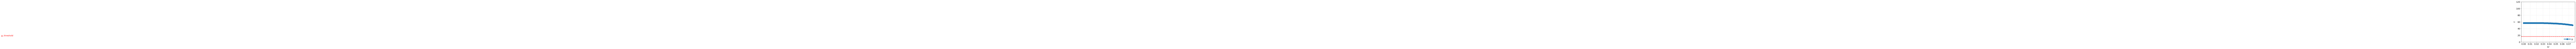

In [ ]:
plt.plot(
    w_plot, t_w[:-1],
    'o-', label='$g_c$',
    linewidth=4, markersize=10
)

# linha horizontal (caso constante)
plt.axhline(
    t_w[-1], lw=2.5, ls='--', color='red'
)

# texto explicativo acima da linha
plt.text(
    x=w_list[-1] - 4,
    y=t_w[-1] + 0.02 * (max(t_w) - min(t_w)),
    s='$g_0$ threshold',
    color='red',
    fontsize=13,
)

# aumente o tamanho dos ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# legenda com fundo transparente
leg = plt.legend(fontsize=12,     frameon=True,
    facecolor='none',
    framealpha=0.0,
    handlelength=3.5,
    handletextpad=0.5,loc = 'lower right')
leg.get_frame().set_facecolor('none')     # fundo transparente
leg.get_frame().set_edgecolor('none')     # sem borda

#plt.xlim(-0.2,10.2)
plt.ylim(0,120)
plt.ylabel('$\\tau$', fontsize=16)
plt.xlabel('$\\omega$', fontsize=16)
plt.grid(True, alpha=0.3)
#plt.savefig('trigonometric_tau.eps', dpi=300)
plt.tight_layout()
plt.show()


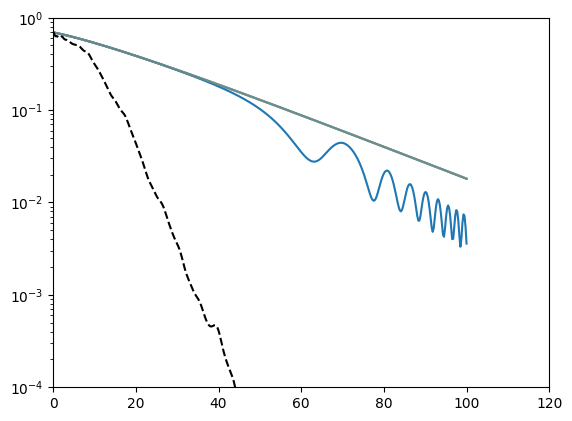

In [ ]:
plt.plot(t, c_list_aberto[-1])
for i in range(0, len(c_list_aberto)):
    if  i < 10:
        plt.plot(t, c_list_aberto[i], alpha=0.3)

plt.plot(t, C_const_aberto, 'k--', label='constante')
plt.xlim(0, 120)
plt.ylim(1e-4,1)
plt.yscale('log')
plt.show()

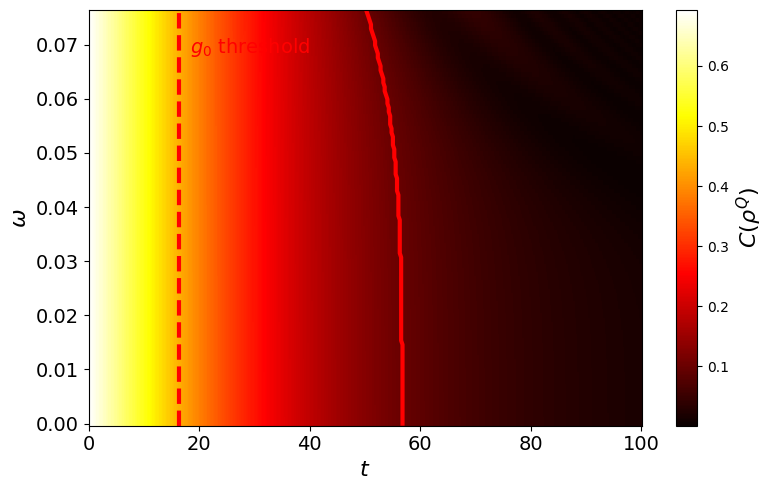

In [ ]:
#=========================================
# PREPARO DA MATRIZ C(w, t)
#=========================================
t_w = np.array(t_w)
eps = 1e-15
C_mat = np.array([np.maximum(c_i, eps) for c_i in c_list_aberto])  # shape (Nw, Nt)

# grade p/ pcolormesh
T, W = np.meshgrid(t, w_plot)  # ambos de shape (Nw, Nt)

plt.figure(figsize=(8, 5))

# HEATMAP
pcm = plt.pcolormesh(T, W, C_mat, shading='auto', cmap='hot')
cbar = plt.colorbar(pcm)
cbar.set_label('$C(\\rho^Q)$', fontsize=16)

# CURVA τ(ω) SOBRE O HEATMAP
plt.plot(
    t_w[:-1],    # agora é x = t
    w_plot,      # y = ω
    '-',
    color='red',
    linewidth=3,
    markersize=10,
    label='$g_c$'
)

# LINHA VERTICAL DO g0 (tempo constante)
threshold_tau = t_w[-1]
plt.axvline(
    threshold_tau,
    lw=3,
    ls='--',
    color='red',
    label='$g_0$'
)

plt.text(
    x=threshold_tau + 0.02*(max(t) - min(t)),
    y=w_plot[-1]*0.9,
    s='$g_0$ threshold',
    color='red',
    fontsize=14,
)

plt.xlabel('$t$', fontsize=16)
plt.ylabel('$\\omega$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 120)
plt.tight_layout()
plt.show()


# Entanglement

In [ ]:
#==========================
# PARAMETERS -
#==========================
eps = 1e-10

t = np.concatenate([
    np.linspace(0, 1, 100),
    np.linspace(1, 30, 400)
])

N = 2       # Qubit Base Size
#Nb = 20   # Field Base Size
wmax = (np.log(2) - np.log(1e-3))/30
w_list = np.linspace(0, wmax, 100)
"""
args = {  'g0': 1,
          'eta': 1,
          'w': 0,
          'kappa': 1e-1,
          'gamma': 0,
          'gamma_phi': 1e-2,
          'coupling': 'exp',
          'phi': 0.5
          }
"""

"\nargs = {  'g0': 1,\n          'eta': 1,\n          'w': 0,\n          'kappa': 1e-1,\n          'gamma': 0,\n          'gamma_phi': 1e-2,\n          'coupling': 'exp',\n          'phi': 0.5\n          }\n"

In [ ]:
#==========================
# INITIAL STATE
#==========================
#alpha = 3
phi0 = (qt.tensor(qt.basis(N,0), qt.coherent(Nb, alpha)) + qt.tensor(qt.basis(N,1), qt.coherent(Nb, -alpha))).unit()
#phi0 = (tensor(basis(N,0), coherent(Nb, -alpha)) + tensor(basis(N,1), coherent(Nb, alpha))).unit()

In [ ]:
#==========================
# OPERATORS
#==========================
sz, sp, sm, b, nb, I = get_operators(N, Nb)
obs_list=[sz, nb, nb**2]

#==========================
# DECAY AND DEPHASING
#==========================
c_ops = get_collapse(args, sm, sz, b)

#==========================
# CLOSED HAMILTONIAN
#==========================
H1 = closed(args, b, sp, sm)

In [ ]:
state0 = phi0.copy()
sol_const_aberto = solve(H1, state0, t, c_ops, obs_list, args)
sol_const = solve(H1, state0, t, None, obs_list, args, open=False)

E_const_aberto = entanglement(sol_const_aberto.states)
E_const = entanglement(sol_const.states)

E_list_aberto = []
E_list = []

for w in tqdm(w_list):
  #state0 = psi0
  args['w'] = w
  H = open(b, sp, sm)

  sol_var_aberto = solve(H, state0, t, c_ops, obs_list, args)
  sol_var = solve(H, state0, t,  None, obs_list, args)

  E_var_aberto = entanglement(sol_var_aberto.states)
  E_var = entanglement(sol_var.states)
  E_list.append(E_var)
  E_list_aberto.append(E_var_aberto)

100%|██████████| 100/100 [21:28<00:00, 12.88s/it]


In [ ]:
# ===============================
# SALVAR EM CSV — colunas = frequências reais
# ===============================


# gera nome base
tag = make_tag(N, Nb, args)

# -------------------------------
# Converte listas → matrizes
# -------------------------------
Cmat_aberto  = np.vstack(E_list_aberto)   # (n_w, n_t)
Cmat_fechado = np.vstack(E_list)          # (n_w, n_t)

# ===============================
# Linhas = tempo, colunas = frequências
# ===============================
freq_cols = [float(w) for w in w_list]   # <<< nomes das colunas exatamente iguais às frequências

df_aberto  = pd.DataFrame(Cmat_aberto.T,  index=t, columns=freq_cols)
df_fechado = pd.DataFrame(Cmat_fechado.T, index=t, columns=freq_cols)

# constantes: 1 coluna por tipo, index = tempo
df_const_aberto = pd.DataFrame({"E_const_aberto": E_const_aberto}, index=t)
df_const        = pd.DataFrame({"E_const":        E_const},        index=t)

# -------------------------------
# Nomes dos arquivos
# -------------------------------
file_aberto       = f"./experiments/entanglement/{args['coupling']}/entanglement_aberto_alpha{alpha}_{tag}.csv"
file_fechado      = f"./experiments/entanglement/{args['coupling']}/entanglement_fechado_alpha{alpha}_{tag}.csv"
file_const_aberto = f"./experiments/entanglement/{args['coupling']}/entanglement_const_aberto_alpha{alpha}_{tag}.csv"
file_const        = f"./experiments/entanglement/{args['coupling']}/entanglement_const_alpha{alpha}_{tag}.csv"

# -------------------------------
# Salva tudo em CSV
# -------------------------------
df_aberto.to_csv(file_aberto)
df_fechado.to_csv(file_fechado)
df_const_aberto.to_csv(file_const_aberto)
df_const.to_csv(file_const)

print("CSV gerados:")
print(" -", file_aberto)
print(" -", file_fechado)
print(" -", file_const_aberto)
print(" -", file_const)


CSV gerados:
 - ./experiments/entanglement/exp/entanglement_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/entanglement/exp/entanglement_fechado_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/entanglement/exp/entanglement_const_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/entanglement/exp/entanglement_const_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv


In [ ]:
t_w = []
#limite = 1e-3
w_plot = w_list
for i, E_var in enumerate(E_list_aberto):
    E_var = np.array(E_var)
    idx = np.where(E_var < limite)[0]
    if len(idx) > 0:
        print(f"w = {w_plot[i]:.3f} → t = {t[idx[0]]:.4f}")
    else:
        print(f"w = {w_plot[i]:.3f} → nunca cai abaixo de {limite:.0e}")
    t_w.append(t[idx[0]])

idx = np.where(np.array(E_const_aberto)<limite)[0]
t_w.append(t[idx[0]])


w = 0.000 → t = 3.0351
w = 0.003 → t = 3.0351
w = 0.005 → t = 3.0351
w = 0.008 → t = 3.0351
w = 0.010 → t = 3.0351
w = 0.013 → t = 3.0351
w = 0.015 → t = 3.0351
w = 0.018 → t = 3.0351
w = 0.020 → t = 3.0351
w = 0.023 → t = 3.0351
w = 0.026 → t = 3.0351
w = 0.028 → t = 3.0351
w = 0.031 → t = 3.0351
w = 0.033 → t = 3.0351
w = 0.036 → t = 3.0351
w = 0.038 → t = 3.0351
w = 0.041 → t = 3.0351
w = 0.044 → t = 3.0351
w = 0.046 → t = 3.0351
w = 0.049 → t = 3.0351
w = 0.051 → t = 3.0351
w = 0.054 → t = 3.0351
w = 0.056 → t = 3.0351
w = 0.059 → t = 3.0351
w = 0.061 → t = 3.0351
w = 0.064 → t = 3.0351
w = 0.067 → t = 3.0351
w = 0.069 → t = 3.0351
w = 0.072 → t = 3.0351
w = 0.074 → t = 3.0351
w = 0.077 → t = 3.0351
w = 0.079 → t = 3.0351
w = 0.082 → t = 3.0351
w = 0.084 → t = 3.0351
w = 0.087 → t = 3.0351
w = 0.090 → t = 3.0351
w = 0.092 → t = 3.0351
w = 0.095 → t = 3.0351
w = 0.097 → t = 3.0351
w = 0.100 → t = 3.0351
w = 0.102 → t = 3.0351
w = 0.105 → t = 3.0351
w = 0.107 → t = 3.0351
w = 0.110 →

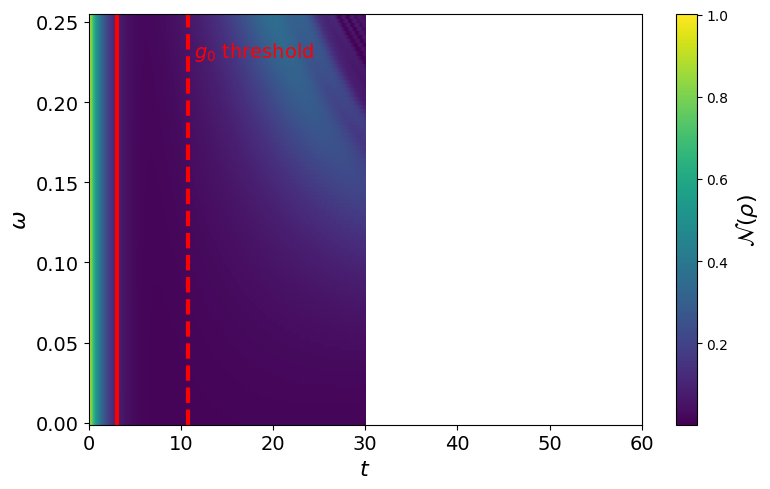

In [ ]:
#=========================================
# PREPARO DA MATRIZ C(w, t)
#=========================================
#t_w = np.array(t_w)
eps = 1e-15
C_mat = np.array([np.maximum(c_i, eps) for c_i in E_list_aberto])  # shape (Nw, Nt)

# grade p/ pcolormesh
T, W = np.meshgrid(t, w_plot)  # ambos de shape (Nw, Nt)

plt.figure(figsize=(8, 5))

# HEATMAP
pcm = plt.pcolormesh(T, W, C_mat, shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm)
cbar.set_label('$\\mathcal{N}(\\rho)$', fontsize=16)

# CURVA τ(ω) SOBRE O HEATMAP

plt.plot(
    t_w[:-1],    # agora é x = t
    w_plot,      # y = ω
    '-',
    color='red',
    linewidth=3,
    markersize=10,
    label='$g_c$'
)

# LINHA VERTICAL DO g0 (tempo constante)
threshold_tau = t_w[-1]
plt.axvline(
    threshold_tau,
    lw=3,
    ls='--',
    color='red',
    label='$g_0$'
)

plt.text(
    x=threshold_tau + 0.02*(max(t) - min(t)),
    y=w_plot[-1]*0.9,
    s='$g_0$ threshold',
    color='red',
    fontsize=14,
)

plt.xlabel('$t$', fontsize=16)
plt.ylabel('$\\omega$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 60)
plt.tight_layout()
plt.show()


# Wigner

In [ ]:
#==========================
# PARAMETERS -
#==========================
eps = 1e-10

t = np.concatenate([
    np.linspace(0, 1, 100),
    np.linspace(1, 5, 200)
])

N = 2       # Qubit Base Size
#Nb = 40   # Field Base Size
wmax = (1/5) * (np.log(2) - np.log(1e-3))
w_list = np.linspace(0, wmax, 100)
"""
args = {  'g0': 1,
          'eta': 1,
          'w': 0,
          'kappa': 1e-1,
          'gamma': 0,
          'gamma_phi': 1e-2,
          'coupling': 'linear',
          'phi': 0.5
          }
"""

"\nargs = {  'g0': 1,\n          'eta': 1,\n          'w': 0,\n          'kappa': 1e-1,\n          'gamma': 0,\n          'gamma_phi': 1e-2,\n          'coupling': 'linear',\n          'phi': 0.5\n          }\n"

In [ ]:
#==========================
# INITIAL STATE
#==========================
#alpha = 1
#phi0 = qt.tensor(qt.basis(N,0), qt.coherent(Nb, -alpha) + qt.coherent(Nb, alpha)).unit()
phi0 = qt.tensor(qt.basis(N,0), qt.coherent(Nb,alpha) + qt.coherent(Nb,-alpha)).unit()
#phi0 = (tensor(basis(N,0), coherent(Nb, -alpha)) + tensor(basis(N,1), coherent(Nb, alpha))).unit()

In [ ]:
#==========================
# OPERATORS
#==========================
sz, sp, sm, b, nb, I = get_operators(N, Nb)
obs_list=[sz, nb, nb**2]

#==========================
# DECAY AND DEPHASING
#==========================
c_ops = get_collapse(args, sm, sz, b)

#==========================
# CLOSED HAMILTONIAN
#==========================
H1 = closed(args, b, sp, sm)

In [ ]:
def wigner(states, xvec, pvec):
    ns = []
    for _, state in enumerate(states):
        w = qt.wigner(state.ptrace(1), xvec, pvec)
        waux = integrate.simpson(abs(w), xvec)
        aux0 = integrate.simpson(waux, pvec)
        #if aux0 <0: aux0 = 0
        aux = 0.5*(aux0  - 1)
        ns.append(aux)
    return ns

In [ ]:
xvec = np.linspace(-10, 10, 250)
pvec = xvec.copy()

In [ ]:
state0 = phi0.copy()
sol_const_aberto = solve(H1, state0, t, c_ops, obs_list, args)
sol_const = solve(H1, state0, t, None, obs_list, args, open=False)

W_const_aberto = wigner(sol_const_aberto.states, xvec, pvec)
W_const = wigner(sol_const.states, xvec, pvec)

W_list_aberto = []
W_list = []

for w in tqdm(w_list):
  #state0 = psi0
  args['w'] = w
  H = open(b, sp, sm)

  sol_var_aberto = solve(H, state0, t, c_ops, obs_list, args)
  sol_var = solve(H, state0, t,  None, obs_list, args)

  W_var_aberto = wigner(sol_var_aberto.states, xvec, pvec)
  W_var = wigner(sol_var.states, xvec, pvec)
  W_list.append(W_var)
  W_list_aberto.append(W_var_aberto)

100%|██████████| 100/100 [6:31:30<00:00, 234.90s/it] 


In [ ]:
import pandas as pd

In [ ]:
# ===============================
# SALVAR EM CSV — colunas = frequências reais
# ===============================

# gera nome base
tag = make_tag(N, Nb, args)

# -------------------------------
# Converte listas → matrizes
# -------------------------------
Cmat_aberto  = np.vstack(W_list_aberto)   # (n_w, n_t)
Cmat_fechado = np.vstack(W_list)          # (n_w, n_t)

# ===============================
# Linhas = tempo, colunas = frequências
# ===============================
freq_cols = [float(w) for w in w_list]   # <<< nomes das colunas exatamente iguais às frequências

df_aberto  = pd.DataFrame(Cmat_aberto.T,  index=t, columns=freq_cols)
df_fechado = pd.DataFrame(Cmat_fechado.T, index=t, columns=freq_cols)

# constantes: 1 coluna por tipo, index = tempo
df_const_aberto = pd.DataFrame({"W_const_aberto": W_const_aberto}, index=t)
df_const        = pd.DataFrame({"W_const":        W_const},        index=t)

# -------------------------------
# Nomes dos arquivos
# -------------------------------
file_aberto       = f"./experiments/wigner/{args['coupling']}/wigner_aberto_alpha{alpha}_{tag}.csv"
file_fechado      = f"./experiments/wigner/{args['coupling']}/wigner_fechado_alpha{alpha}_{tag}.csv"
file_const_aberto = f"./experiments/wigner/{args['coupling']}/wigner_const_aberto_alpha{alpha}_{tag}.csv"
file_const        = f"./experiments/wigner/{args['coupling']}/wigner_const_alpha{alpha}_{tag}.csv"

# -------------------------------
# Salva tudo em CSV
# -------------------------------
df_aberto.to_csv(file_aberto)
df_fechado.to_csv(file_fechado)
df_const_aberto.to_csv(file_const_aberto)
df_const.to_csv(file_const)

print("CSV gerados:")
print(" -", file_aberto)
print(" -", file_fechado)
print(" -", file_const_aberto)
print(" -", file_const)


CSV gerados:
 - ./experiments/wigner/exp/wigner_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/wigner/exp/wigner_fechado_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/wigner/exp/wigner_const_aberto_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv
 - ./experiments/wigner/exp/wigner_const_alpha2.23606797749979_N2_Nb40_g01_eta1_kappa01_gamma0_gphi001_coup_exp_phim6907755.csv


In [ ]:
t_w = []
#limite = 1e-3
w_plot = w_list
for i, W_var in enumerate(W_list_aberto):
    W_var = np.array(W_var)
    idx = np.where(W_var < limite)[0]
    if len(idx) > 0:
        print(f"w = {w_plot[i]:.3f} → t = {t[idx[0]]:.4f}")
    else:
        print(f"w = {w_plot[i]:.3f} → nunca cai abaixo de {limite:.0e}")
    t_w.append(t[idx[0]])

idx = np.where(np.array(W_const_aberto)<limite)[0]
t_w.append(t[idx[0]])


w = 0.000 → t = 1.1206
w = 0.015 → t = 1.1206
w = 0.031 → t = 1.1206
w = 0.046 → t = 1.1206
w = 0.061 → t = 1.1206
w = 0.077 → t = 1.1206
w = 0.092 → t = 1.1206
w = 0.107 → t = 1.1206
w = 0.123 → t = 1.1206
w = 0.138 → t = 1.1206
w = 0.154 → t = 1.1206
w = 0.169 → t = 1.1206
w = 0.184 → t = 1.1206
w = 0.200 → t = 1.1206
w = 0.215 → t = 1.1206
w = 0.230 → t = 1.1206
w = 0.246 → t = 1.1206
w = 0.261 → t = 1.1206
w = 0.276 → t = 1.1206
w = 0.292 → t = 1.1206
w = 0.307 → t = 1.1206
w = 0.322 → t = 1.1206
w = 0.338 → t = 1.1206
w = 0.353 → t = 1.1206
w = 0.369 → t = 1.1206
w = 0.384 → t = 1.1206
w = 0.399 → t = 1.1206
w = 0.415 → t = 1.1206
w = 0.430 → t = 1.1206
w = 0.445 → t = 1.1206
w = 0.461 → t = 1.1206
w = 0.476 → t = 1.1206
w = 0.491 → t = 1.1206
w = 0.507 → t = 1.1206
w = 0.522 → t = 1.1206
w = 0.537 → t = 1.1206
w = 0.553 → t = 1.1206
w = 0.568 → t = 1.1206
w = 0.584 → t = 1.1206
w = 0.599 → t = 1.1206
w = 0.614 → t = 1.1206
w = 0.630 → t = 1.1206
w = 0.645 → t = 1.1206
w = 0.660 →

In [ ]:
from matplotlib.colors import LogNorm

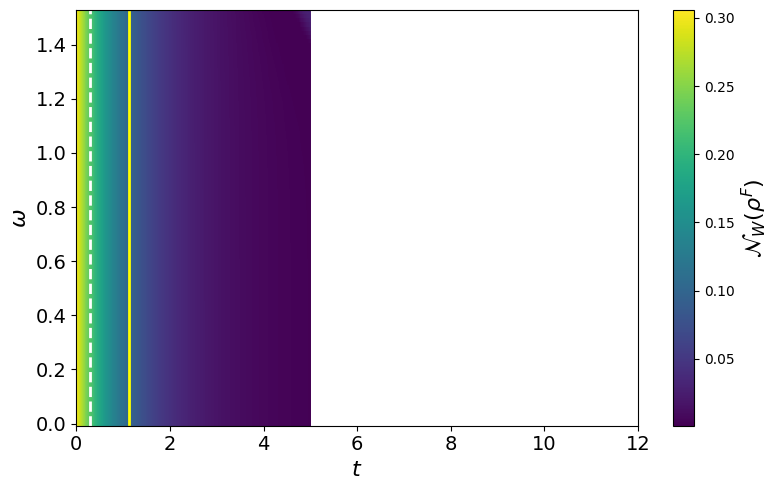

In [ ]:
#=========================================
# PREPARO DA MATRIZ C(w, t)
#=========================================
#t_w = np.array(t_w)
eps = 1e-15
C_mat = np.array([np.maximum(c_i, eps) for c_i in W_list_aberto])  # shape (Nw, Nt)

# grade p/ pcolormesh
T, W = np.meshgrid(t, w_plot)  # ambos de shape (Nw, Nt)

plt.figure(figsize=(8, 5))

# HEATMAP
pcm = plt.pcolormesh(T, W, C_mat, vmin=1e-3,shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm)
cbar.set_label('$\\mathcal{N}_W (\\rho^{F})$', fontsize=16)

# CURVA τ(ω) SOBRE O HEATMAP

plt.plot(
    t_w[:-1],    # agora é x = t
    w_plot,      # y = ω
    '-',
    color='yellow',
    linewidth=2,
    markersize=10,
    label='$g_c$'
)

# LINHA VERTICAL DO g0 (tempo constante)
threshold_tau = t_w[-1]
plt.axvline(
    threshold_tau,
    lw=2,
    ls='--',
    color='white',
    label='$g_0$'
)

"""
plt.text(
    x=threshold_tau + 0.02*(max(t) - min(t)),
    y=w_plot[-1]*0.9,
    s='$g_0$ threshold',
    color='white',
    fontsize=14,
)
"""
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$\\omega$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 12)
plt.tight_layout()
plt.show()
